<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Construct the confidence interval

# Programming Preliminaries

In [27]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIRS = ["/home/ubuntu/advancing-biomedical-models/common"]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_12"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIRS = ["/content/drive/MyDrive/Winter 2021/common"]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/12_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [2]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries
import model_fitting as mf

# Model and Data

In [3]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]
PARAMETER_ESTIMATES = ModelFitter.mkParameters(parametersToFit=PARAMETERS_TO_FIT)
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,5.00000000,5.0,0.00000000,10.0000000,True
k2,5.00000000,5.0,0.00000000,10.0000000,True


In [4]:
# Globals
NUM_POINTS = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [5]:
fittedTS = ModelFitter.runSimulation(roadrunner=MODEL, numPoint=NUM_POINTS, endTime=SIM_TIME, returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   5.422509 -0.274711 -0.072988
1.034483   4.525383  0.388417  0.077693
2.068966   4.751367  1.106745  0.305599
3.103448   3.481152  1.056880 -0.103494
4.137931   3.301779  1.113968  0.571173
5.172414   3.361731  1.386225  0.821136
6.206897   2.171559  0.980565  1.040471
7.241379   2.507529  1.405331  1.688746
8.275862   2.036850  1.463789  1.509144
9.310345   2.010251  1.141359  1.210584
10.344828  1.820648  1.059639  1.859176
11.379310  1.291536  1.002886  2.260702
12.413793  1.421881  0.794098  2.116807
13.448276  1.799913  1.004954  2.944874
14.482759  1.392594  0.719207  3.018612
15.517241  0.549480  0.849260  3.180271
16.551724  1.400086  0.603661  2.574584
17.586207  0.711283  0.662225  3.244850
18.620690  0.159916  0.231060  3.517993
19.655172  0.873925  0.679899  3.578399
20.689655  0.789933  0.812369  3.527292
21.724138  0.392081  0.469887  3.755452
22.758621  0.992431  0.085068  4.375448


In [6]:
def plotData(observedTS):
    """
    Creates a scatter plot of the observed data.
    
    Parameters
    ----------
    observedTS: NamedTimeseries
    
    Returns
    -------
    
    """
    figure, ax = plt.subplots(1)
    for column in observedTS.colnames:
        _ = ax.scatter(observedTS[TIME], observedTS[column])
    _ = plt.legend(observedTS.colnames)
    return figure
        
# Tests
figure = plotData(OBS_TS)
assert(isinstance(figure, matplotlib.figure.Figure))
_ = figure.clear()

<Figure size 432x288 with 0 Axes>

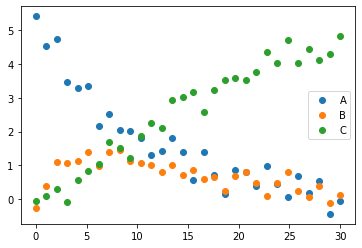

In [7]:
_ = plotData(OBS_TS)

# Bootstrapping Workflow

## Construct a good model.
In the following, we use the same model as the synthetic observations. Of course, in practice, you won't know the "true" model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [8]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



name,value,standard error,relative error,initial value,min,max,vary
k1,0.09892480,0.00296569,(3.00%),3.9388471029827388,0.00000000,10.0000000,True
k2,0.19669306,0.01084079,(5.51%),9.934708833607504,0.00000000,10.0000000,True


In [9]:
print(FITTER.reportFit())

[[Fit Statistics]]
    chi-square         = 7.29589440
    reduced chi-square = 0.08290789
    Akaike info crit   = -222.124810
    Bayesian info crit = -217.125191
[[Variables]]
    k1:  0.09892480 +/- 0.00296569 (3.00%) (init = 3.938847)
    k2:  0.19669306 +/- 0.01084079 (5.51%) (init = 9.934709)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.399


**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [10]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000   0.422509 -0.274711 -0.072988
1.034483   0.011752 -0.050900  0.030640
2.068966   0.676794  0.351729  0.135188
3.103448  -0.197071  0.082864 -0.451255
4.137931  -0.018650 -0.003901  0.009471
5.172414   0.364293  0.182424  0.022374
6.206897  -0.534307 -0.264967 -0.008130
7.241379   0.064873  0.151368  0.385365
8.275862  -0.168199  0.226073 -0.048091
9.310345   0.019696 -0.062223 -0.595278
10.344828  0.023721 -0.097248 -0.187010
11.379310 -0.330597 -0.098891 -0.015389
12.413793 -0.042461 -0.247356 -0.377397
13.448276  0.478014  0.026581  0.245148
14.482759  0.199281 -0.195185  0.126317
15.517241 -0.527755 -0.001632  0.108398
16.551724  0.427638 -0.185222 -0.664084
17.586207 -0.166571 -0.066859 -0.148211
18.620690 -0.632546 -0.440924 -0.017560
19.655172  0.158548  0.062006 -0.088331
20.689655  0.144143  0.245381 -0.259930
21.724138 -0.190890 -0.049454 -0.142236
22.758621  0.466168 -0.389879  0.376658


In [11]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.2824664896944559

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [12]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, observedTS=OBS_TS, residualsTS=RESIDUALS_TS)

In [13]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.011752 -0.440924 -0.377397
1.034483   4.494981  0.041569  0.182241
2.068966   3.347296  0.705563  0.718207
3.103448   4.355018  0.726660  0.259430
4.137931   3.002940  1.179875  0.374692
5.172414   3.463606  1.623829  0.656526
6.206897   2.850009  1.241632  0.671205
7.241379   2.276084  1.337599  0.852126
8.275862   1.677294  1.236084  1.587875
9.310345   2.212966  1.136723  1.932180
10.344828  1.941070  0.759140  1.450908
11.379310  2.298927  1.097876  2.384489
12.413793  1.421881  0.766743  2.446113
13.448276  0.957494  1.204447  3.247523
14.482759  1.174664  1.065760  3.231032
15.517241  1.100956  0.753643  3.619669
16.551724  0.805877  0.971308  3.188406
17.586207  0.513449  0.911509  2.941806
18.620690  0.804215  0.755619  3.780701
19.655172  1.392171  0.422708  3.593742
20.689655  0.448718  0.126064  3.646640
21.724138  0.252374  0.546938  4.445484
22.758621  0.591136  0.034022  4.546587


In [14]:
# Try running this several times to see how values change.
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.144143 -0.271146  0.108398
1.034483   4.493028 -0.001608  0.385790
2.068966   3.906374  0.507661  0.162280
3.103448   3.877504  1.125384  0.474078
4.137931   3.464572  1.269237  0.421120
5.172414   3.280373  1.449182  0.907160
6.206897   3.128374  1.196079  0.975613
7.241379   2.601204  1.006608  1.086635
8.275862   2.007978  0.847837  1.308149
9.310345   1.948095  1.354950  2.182520
10.344828  2.224565  1.090028  2.068560
11.379310  1.425062  1.185411  2.652749
12.413793  1.443739  0.770308  2.446113
13.448276  1.301297  0.927474  3.247523
14.482759  1.557607  1.140465  2.876906
15.517241  1.754030  0.585924  3.180271
16.551724  1.450462  1.140612  3.098086
17.586207  1.077136  0.791091  3.528249
18.620690  1.220100  0.605125  4.083350
19.655172  0.937787  0.352926  3.651342
20.689655  0.479218  0.469740  4.163880
21.724138  1.060985  0.517709  3.648601
22.758621  0.195666  0.203800  3.983402


### Repeatedly estimate parameter values

In [15]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=10):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 5
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == len(estimateDct[PARAMETERS_TO_FIT[1]]))
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == numIteration)

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (30.000000000000004) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 30.000000000000004, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



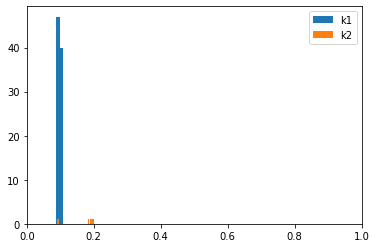

In [16]:
ESTIMATE_DCT = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=100)
def plotHist(parameter):
    _ = plt.hist(ESTIMATE_DCT[parameter],bins=1000)
    plt.xlim([0, 1])

for parameter in PARAMETERS_TO_FIT:
    plotHist(parameter)
_ = plt.legend(PARAMETERS_TO_FIT)

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [17]:
np.quantile(range(10), [.10, .90])

array([0.9, 8.1])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

In [18]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

k1: [0.08698957 7.92952419]
k2: [0.10712079 5.17536423]


**Questions**
1. Why does ``k1`` have such a wide confidence interval?

# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [19]:
# Model used in this example
NEW_MODEL = """
     $A -> B; k1*$A
     $A -> C; k2*$A
     C -> D; k3*C
     D + B -> $E; k4*D*B
     
     A = 5;
     B = 10;
     C = 8;
     D = 4;
     E = 2
     k1 = 0.5
     k2 = 0.1
     k3 = 1.3;
     k4 = 1;
"""

In [20]:
# Solution: Constants
NEW_NUM_POINT = 100
NEW_END_TIME = 5
NEW_NOISE_STD = 0.4

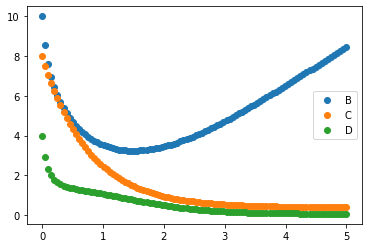

In [21]:
# Plot of the ground truth model
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=0.0)
_ = plotData(synthesizer.calculate())

We are going to estimate the parameters ``k1``, ``k2``, ``k3``, and the constant value of ``A``.

In [22]:
NEW_PARAMETERS_TO_FIT = ["k1", "k2", "k3", "A"]

## Generate randomized observations

**Question**
1. Generate data with 100 points over 30 s and a stardard deviation of 0.4.

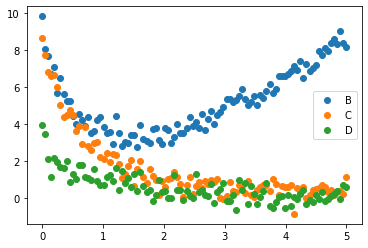

In [23]:
# Solution

fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NEW_NOISE_STD)
NEW_OBS_TS = synthesizer.calculate()
_ = plotData(NEW_OBS_TS)

**Questions**
1. For what part of these data will it be difficult to estimate the dynamics and therefore the kinetics constants?

## Construct a good fit of the model
**Question**
1. Find a good fit for the model.
1. How good are the estimates relative to ground truth? If there are bad estimates, explain why.
1. Plot the model using the estimated values.

In [24]:
# Solution
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTED_TS = NEW_FITTER.fittedTS
NEW_PARAMETER_ESTIMATES = NEW_FITTER.params
NEW_PARAMETER_ESTIMATES

/home/ubuntu/advancing-biomedical-models/cls/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (5.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 5.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



name,value,standard error,relative error,initial value,min,max,vary
k1,8.52540290,440.022083,(5161.31%),0.0612902605266652,0.00000000,10.0000000,True
k2,1.89208548,97.6704011,(5162.05%),8.413903771539179,0.00000000,10.0000000,True
k3,1.33825391,0.00550351,(0.41%),1.9631477885581994,0.00000000,10.0000000,True
A,0.30194088,15.5825558,(5160.80%),8.408094357202868,0.00000000,10.0000000,True


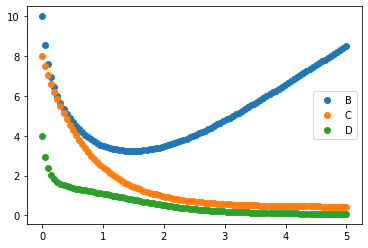

In [25]:
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False, parameters=NEW_PARAMETER_ESTIMATES)
_ = plotData(fittedTS)

## Estimate the residuals

## Construct bootstrap estimates

# Bootstrapping With SBstoat

In [26]:
NEW_FITTER.bootstrap(numIteration=500, reportInterval=100)
print(NEW_FITTER.reportBootstrap())




13.028173: ***Running bootstrap for 500 successful iterations with 5 processes.***

16.217070:     (Bootstrap completed 100 total iterations with 100 successes.)

19.394968:     (Bootstrap completed 200 total iterations with 200 successes.)

22.285034:     (Bootstrap completed 300 total iterations with 300 successes.)

25.560329:     (Bootstrap completed 400 total iterations with 400 successes.)

29.038584:     (Process 3: completed bootstrap.)

29.104188:     (Process 2: completed bootstrap.)

29.123893:     (Bootstrap completed 500 total iterations with 500 successes.)

29.127315:     (Process 1: completed bootstrap.)

29.199378:     (Process 5: completed bootstrap.)

29.276128:     (Process 4: completed bootstrap.)


29.334330: 
 **500 bootstrap estimates of parameters.



29.335709: ***
Bootstrap Report.
Total iterations: 500
Total simulation: 500
k1
  mean: 1.66646198619807
  std: 2.5632854804215084
  [2.5, 50, 97.55] Percentiles: [2.54221648e-08 3.34457110e-02 9.18371292e+00]
